In [7]:
!pip install ta
! pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00


Fetching data for BTC-USD (5m interval)...
Data fetched successfully. Shape: (17060, 7)
                             open          high           low         close  \
Datetime                                                                      
2025-02-24 00:00:00  96267.851562  96309.171875  96228.976562  96228.976562   
2025-02-24 00:05:00  96255.078125  96351.078125  96255.078125  96351.078125   
2025-02-24 00:10:00  96408.703125  96472.414062  96408.703125  96458.867188   
2025-02-24 00:15:00  96473.937500  96473.937500  96342.500000  96387.296875   
2025-02-24 00:20:00  96412.750000  96412.750000  96376.437500  96376.437500   

                        volume  dividends  stock splits  
Datetime                                                 
2025-02-24 00:00:00          0        0.0           0.0  
2025-02-24 00:05:00          0        0.0           0.0  
2025-02-24 00:10:00  200006656        0.0           0.0  
2025-02-24 00:15:00  706436096        0.0           0.0  
2025-02-24

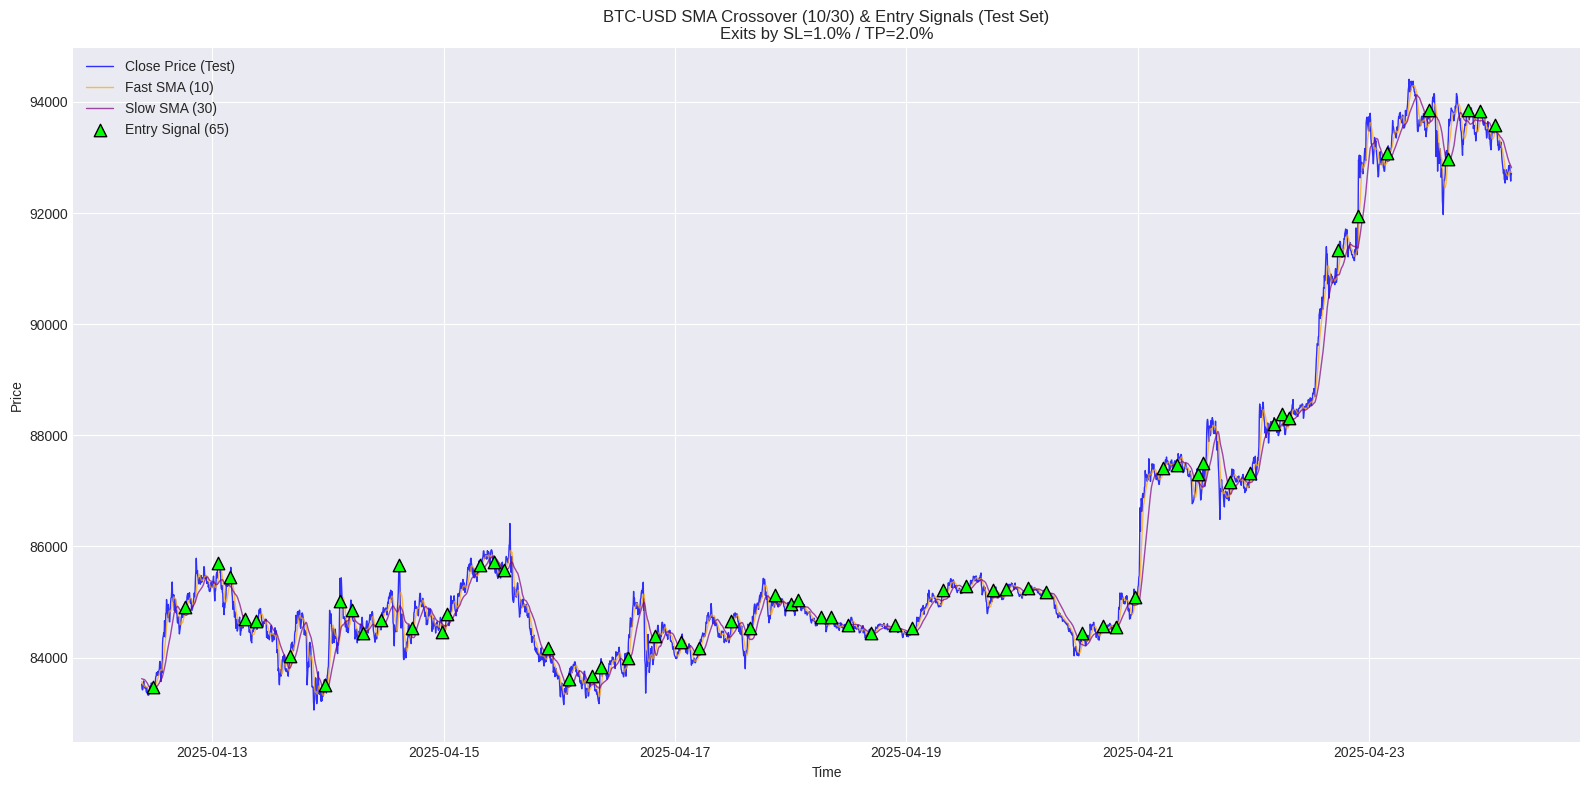


--- Process Complete ---


In [20]:
# %%writefile sma_crossover_btc_sl_tp_v2.py # Updated filename version
import yfinance as yf
import pandas as pd
import numpy as np
import ta # Technical Analysis library
# from sklearn.preprocessing import MinMaxScaler # No longer needed for SMA
# from sklearn.metrics import mean_squared_error # No longer needed for SMA
# import tensorflow as tf # No longer needed for SMA
# from tensorflow.keras.models import Sequential # No longer needed for SMA
# from tensorflow.keras.layers import LSTM, Dense, Dropout # No longer needed for SMA
# from tensorflow.keras.callbacks import EarlyStopping # No longer needed for SMA
import matplotlib.pyplot as plt
import vectorbt as vbt
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# tf.get_logger().setLevel('ERROR') # No longer needed for SMA

# --- Configuration ---
# Data Parameters
TICKER = 'BTC-USD'
PERIOD = '60d'
INTERVAL = '5m'
# LOOK_BACK = 60        # LSTM parameter, not needed for SMA crossover
TEST_SIZE = 0.2        # Still used to define the backtest period

# --- Strategy & Backtesting Parameters ---

# ---- SMA Crossover Parameters ----
FAST_SMA_WINDOW = 10 # e.g., 10 * 5 minutes = 50 minutes
SLOW_SMA_WINDOW = 30 # e.g., 30 * 5 minutes = 2.5 hours
# ---- End SMA Parameters ----

# ---- Stop-Loss and Take-Profit Parameters ----
SL_PERCENT = 0.010  # Stop Loss at 1.0% below entry price
TP_PERCENT = 0.020  # Take Profit at 2.0% above entry price
# ---- End SL/TP Parameters ----

INIT_CASH = 10000
FEE = 0.001           # e.g., 0.1% fee per trade
SLIPPAGE = 0.0005     # e.g., 0.05% slippage per trade (Total 0.15% round-trip cost before profit)

# --- 1. Data Acquisition ---
print(f"Fetching data for {TICKER} ({INTERVAL} interval)...")
try:
    stock_data = yf.Ticker(TICKER).history(period=PERIOD, interval=INTERVAL, auto_adjust=True)
    if stock_data.empty:
        raise ValueError(f"No data found for {TICKER}. Try a shorter period or check ticker.")
    stock_data.columns = [col.lower() for col in stock_data.columns]
    if stock_data.index.tz is not None:
        stock_data.index = stock_data.index.tz_localize(None)
    print(f"Data fetched successfully. Shape: {stock_data.shape}")
    print(stock_data.head())
except Exception as e:
    print(f"Error fetching data: {e}")
    # Simplified error handling for brevity
    exit()

# --- 2. Feature Engineering (Minimal - only need close for SMA) ---
print("Preparing data...")
# Keep the original OHLCV data, add SMAs later
features_df = stock_data[['open', 'high', 'low', 'close', 'volume']].copy()

# Optional: Could still add TA features if the SMA strategy were to be combined later
# But for simple SMA crossover, only 'close' is strictly needed.

# --- Data Cleaning (Handle potential NaNs/Infs in OHLCV - unlikely but safe) ---
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
initial_rows = len(features_df)
features_df.dropna(inplace=True) # Drop rows if OHLCV has NaNs
rows_dropped = initial_rows - len(features_df)
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows with NaNs in OHLCV data.")

if features_df.empty:
    print("Error: No data remaining after cleaning OHLCV.")
    exit()
print(f"Data cleaned. Shape after cleaning: {features_df.shape}")


# --- Define Test Period Indices ---
# We still split the *indices* to know which part of the data to backtest on
split_idx_data = int(len(features_df) * (1 - TEST_SIZE))
test_indices_full = features_df.index[split_idx_data:]

if test_indices_full.empty:
    print("Error: Test period is empty based on TEST_SIZE. Increase data period or decrease TEST_SIZE.")
    exit()

print(f"Test period defined. Starts at: {test_indices_full[0]}, Ends at: {test_indices_full[-1]}")

# --- Calculate SMAs ---
print(f"Calculating SMAs (Fast: {FAST_SMA_WINDOW}, Slow: {SLOW_SMA_WINDOW})...")
close_prices = features_df['close']
fast_sma = ta.trend.sma_indicator(close_prices, window=FAST_SMA_WINDOW)
slow_sma = ta.trend.sma_indicator(close_prices, window=SLOW_SMA_WINDOW)

# --- Generate SMA Crossover Signals ---
# Use vectorbt's built-in crossover detection for simplicity and robustness
# `crossed_above` returns True on the bar *after* the actual crossover happened
entries = vbt.MA.run(close_prices, FAST_SMA_WINDOW).ma_crossed_above(vbt.MA.run(close_prices, SLOW_SMA_WINDOW))
# Optional: Generate exit signals if needed (e.g., cross below)
# exits = vbt.MA.run(close_prices, FAST_SMA_WINDOW).ma_crossed_below(vbt.MA.run(close_prices, SLOW_SMA_WINDOW))

# --- Prepare Data for Backtest (Align price data and signals to the test period) ---
print("Preparing data for vectorbt backtest...")

# Select the entry signals that fall within our defined test period
# Use .loc[] for safety with potential non-monotonic index, fillna just in case
entries_test = entries.loc[test_indices_full].fillna(False)


# Select the price data for the test period
# Ensure alignment by reindexing price data to the signal index (handles potential missing dates/times)
price_data_test = close_prices.loc[entries_test.index]

# --- Sanity Checks ---
print(f"\nNumber of Entry Signals in Test Period: {entries_test.sum()}")

if entries_test.sum() == 0:
    print("Warning: No SMA crossover entry signals generated in the test period.")
    print("Consider adjusting SMA windows or checking data.")
    # Exit or continue based on whether you want to see plots even without trades
    # exit()

if price_data_test.empty or len(price_data_test) != len(entries_test):
    print("Error: Price data mismatch with entry signals AFTER alignment for test period.")
    exit()
if not price_data_test.index.equals(entries_test.index):
    print("Error: Price data index does not match entry signal index AFTER alignment.")
    exit()


# --- Run Vectorbt Backtest with SL/TP ---
print("\nRunning vectorbt backtest with Stop-Loss and Take-Profit...")
print(f"Stop-Loss: {SL_PERCENT*100:.2f}%")
print(f"Take-Profit: {TP_PERCENT*100:.2f}%")

# Only run if there are entries to avoid errors
if entries_test.sum() > 0:
    portfolio = vbt.Portfolio.from_signals(
        close=price_data_test,          # Use the correctly aligned close prices for the test period
        entries=entries_test,           # Use the aligned entry signals for the test period
        # exits=exits_test,             # Uncomment if using crossover exits instead of/with SL/TP
        freq='5T',                      # Ensure this matches your INTERVAL
        init_cash=INIT_CASH,
        fees=FEE,
        slippage=SLIPPAGE,
        sl_stop=SL_PERCENT,             # Stop loss percentage
        tp_stop=TP_PERCENT,             # Take profit percentage
    )

    # --- Analyze Backtest Results ---
    print("\n--- Backtest Results (SMA Crossover with SL/TP) ---")
    stats = portfolio.stats()
    print(stats)



    # --- Plotting ---
    print("\nGenerating plots...")
    try:
        plt.style.use('seaborn-v0_8-darkgrid')

        # 1. Price vs SMAs Plot with Entry Signals
        plt.figure(figsize=(16, 8))
        plot_indices = price_data_test.index # Use index from the final price data used in backtest

        plt.plot(plot_indices, price_data_test.loc[plot_indices].values, label='Close Price (Test)', alpha=0.8, linewidth=1.0, color='blue')
        # Plot SMAs aligned to the test period index
        plt.plot(plot_indices, fast_sma.loc[plot_indices].values, label=f'Fast SMA ({FAST_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='orange')
        plt.plot(plot_indices, slow_sma.loc[plot_indices].values, label=f'Slow SMA ({SLOW_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='purple')

        # Plot entry points
        entry_points = price_data_test.loc[plot_indices][entries_test.loc[plot_indices]]
        plt.scatter(entry_points.index, entry_points.values, marker='^', color='lime', label=f'Entry Signal ({entries_test.sum()})', s=80, alpha=1.0, edgecolors='black', zorder=5)

        plt.title(f'{TICKER} SMA Crossover ({FAST_SMA_WINDOW}/{SLOW_SMA_WINDOW}) & Entry Signals (Test Set)\nExits by SL={SL_PERCENT*100:.1f}% / TP={TP_PERCENT*100:.1f}%')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        # 2. Vectorbt Portfolio Plot (Will show actual trades based on SL/TP)
        fig = portfolio.plot(
            settings=dict(plot_cash=True)
            )
        fig.update_layout(title=f'{TICKER} SMA Crossover Backtest Performance ({INTERVAL}) with SL/TP')
        fig.show()

        # 3. Model Training History Plot - REMOVED (No LSTM model trained)

    except Exception as e:
        print(f"Could not generate plots: {e}")

else:
    # Specific message if no SMA crossover signals were generated in the test period
    print("\nSkipping backtest analysis and plotting as no entry signals were generated.")
    # Optionally plot price and SMAs anyway
    plt.figure(figsize=(16, 8))
    plot_indices = price_data_test.index # Should still be valid
    if not price_data_test.empty and not fast_sma.loc[plot_indices].empty and not slow_sma.loc[plot_indices].empty:
        plt.plot(plot_indices, price_data_test.loc[plot_indices].values, label='Close Price (Test)', alpha=0.8, linewidth=1.0, color='blue')
        plt.plot(plot_indices, fast_sma.loc[plot_indices].values, label=f'Fast SMA ({FAST_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='orange')
        plt.plot(plot_indices, slow_sma.loc[plot_indices].values, label=f'Slow SMA ({SLOW_SMA_WINDOW})', alpha=0.7, linewidth=1.0, color='purple')
        plt.title(f'{TICKER} Price & SMAs (Test Set) - No Crossover Entries')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not generate diagnostic plot - data missing or empty.")


print("\n--- Process Complete ---")